In [1]:
import os
import pickle
import numpy as np
import json
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
COCO_2017_DATA_PATH = "/kaggle/input/coco-2017-dataset/coco2017"
CAPTION_PATH = "/kaggle/input/caption-coco2017-tqm"
WORKING_DIR = "/kaggle/working/"
MODEL_DIR = "/kaggle/input/model-check-point/Img_caption_model (2).keras"

# Extract image feature

## Use to first time using an set of image

In [3]:
#load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
# summarize
model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# extract feature from image
features_train = {}
directory = os.path.join(COCO_2017_DATA_PATH, "val2017")
for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + "/" + img_name
    image = load_img(img_path, target_size=(224, 224))
    # conver image pixel to np array
    image = img_to_array(image)
    # reshape data for model 
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image i d
    image_id = img_name.split('.')[0]
    # store feature 
    features_train[image_id] = feature

  0%|          | 0/5000 [00:00<?, ?it/s]

I0000 00:00:1734059154.199968      94 service.cc:145] XLA service 0x7c66b0004ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734059154.200016      94 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734059154.200022      94 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734059156.847837      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [5]:
# store feature in pickle
pickle.dump(features_train, open(os.path.join(WORKING_DIR, 'features_val.pkl'), 'wb'))

## For the second use, just up load the features file extracted

In [4]:
# load train feature from pickle
with open(os.path.join('/kaggle/input/feature-train/features_train.pkl'), 'rb') as file:
    features_train = pickle.load(file)

In [5]:
# load validation feature from pickle
with open(os.path.join('/kaggle/input/features-val/features_val.pkl'), 'rb') as file:
    features_val = pickle.load(file)

# Load the caption data

In [6]:
# Train data
with open(os.path.join(CAPTION_PATH, "CoCo_transform_train2017.json"), 'r') as file:
    mapping_train_origin = json.load(file)
mapping_train = dict()

for key in mapping_train_origin:
    mapping_train[key.split('.')[0]] = mapping_train_origin[key]

len(mapping_train)

118287

In [7]:
# validation data
with open(os.path.join(CAPTION_PATH, "CoCo_transform_val2017.json"), 'r') as file:
    mapping_val_origin = json.load(file)
mapping_val = dict()

for key in mapping_val_origin:
    mapping_val[key.split('.')[0]] = mapping_val_origin[key]

len(mapping_val)

5000

# Processing data

In [8]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'seqstart ' + " ".join([word for word in caption.split() if len(word)>1]) + ' seqend'
            captions[i] = caption

In [9]:
# before processing of text
mapping_train['000000000092']

['A white plate with a brownie and white frosting.',
 'A piece of chocolate cake on top of a white plate.',
 'a chocolate cake and a fork ready to be eat',
 'A chocolate desert on a plate with a fork. ',
 'A piece of chocolate dessert on a plate with a napkin and a fork.']

In [10]:
# Preprocessing text
clean(mapping_train)
clean(mapping_val)

In [11]:
# after preprocessing of text
mapping_train['000000000092']

['seqstart white plate with brownie and white frosting. seqend',
 'seqstart piece of chocolate cake on top of white plate. seqend',
 'seqstart chocolate cake and fork ready to be eat seqend',
 'seqstart chocolate desert on plate with fork. seqend',
 'seqstart piece of chocolate dessert on plate with napkin and fork. seqend']

In [12]:
all_train_captions = []
for key in mapping_train:
    for caption in mapping_train[key]:
        all_train_captions.append(caption)

In [13]:
len(all_train_captions)

591753

In [14]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_train_captions)
vocab_size = len(tokenizer.word_index) + 1

In [15]:
vocab_size

27551

In [16]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_train_captions)
max_length

49

# Data genertor

In [17]:
# Create data generator
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                
                X1, X2, y = list(), list(), list()
                n = 0

# Model creation

In [18]:
EPOCHS = 2
BATCH_SIZE = 64
LEARNING_RATE = 0.001
RESUME = "allow"

## Wandb init

In [19]:
! pip install wandb

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [20]:
import wandb

WANDB_KEY = "3dd6a45df9ccf90a5f0a492af48a0ca09ef28241"

wandb.init(
    project="tqm-Img-captioning-2nd-version",
    resume=RESUME,
    config={
    "learning_rate": LEARNING_RATE,
    "architecture": "VGG16 + LSTM",
    "dataset": "CoCo2017",
    "epochs": 2,
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: ERROR API key must be 40 characters long, yours was 23
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


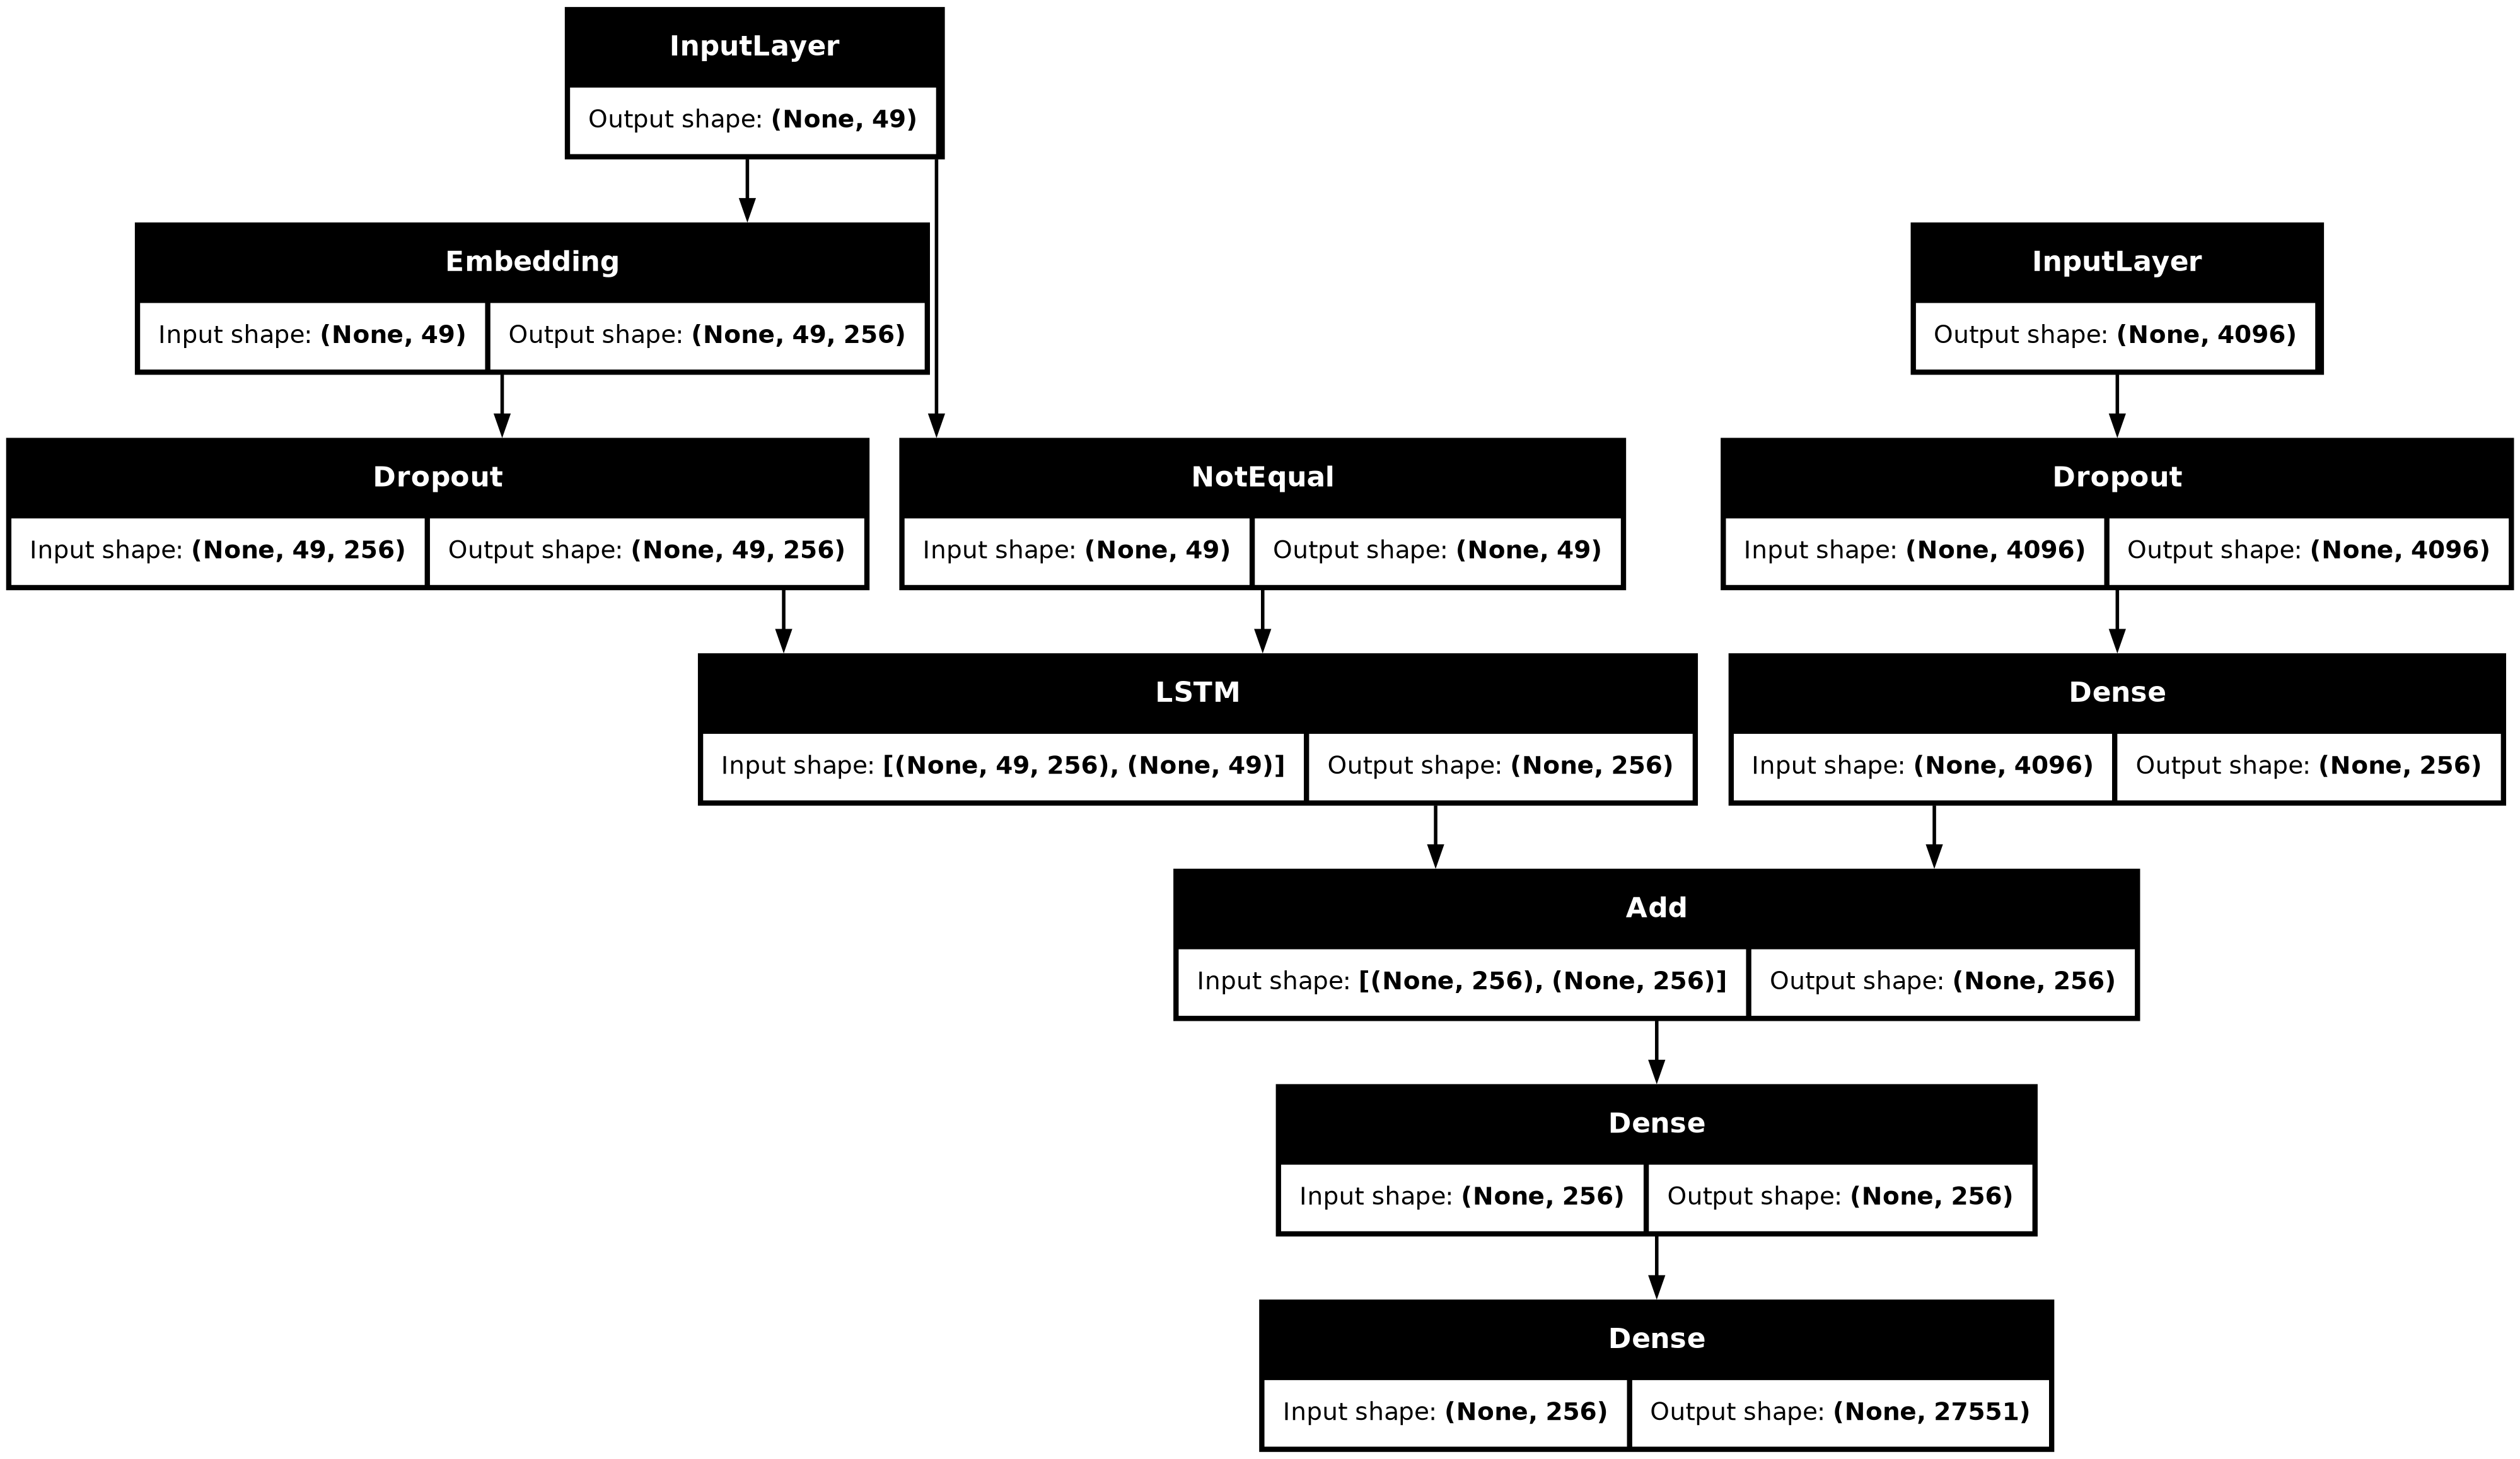

In [21]:
# Encoder model
# Image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

# plot the model
plot_model(model, show_shapes=True)

# Load model for later use or continue training

In [19]:
# load the model
model_dir = MODEL_DIR
print(model_dir)
model = load_model(model_dir)

/kaggle/input/model-check-point/Img_caption_model (2).keras


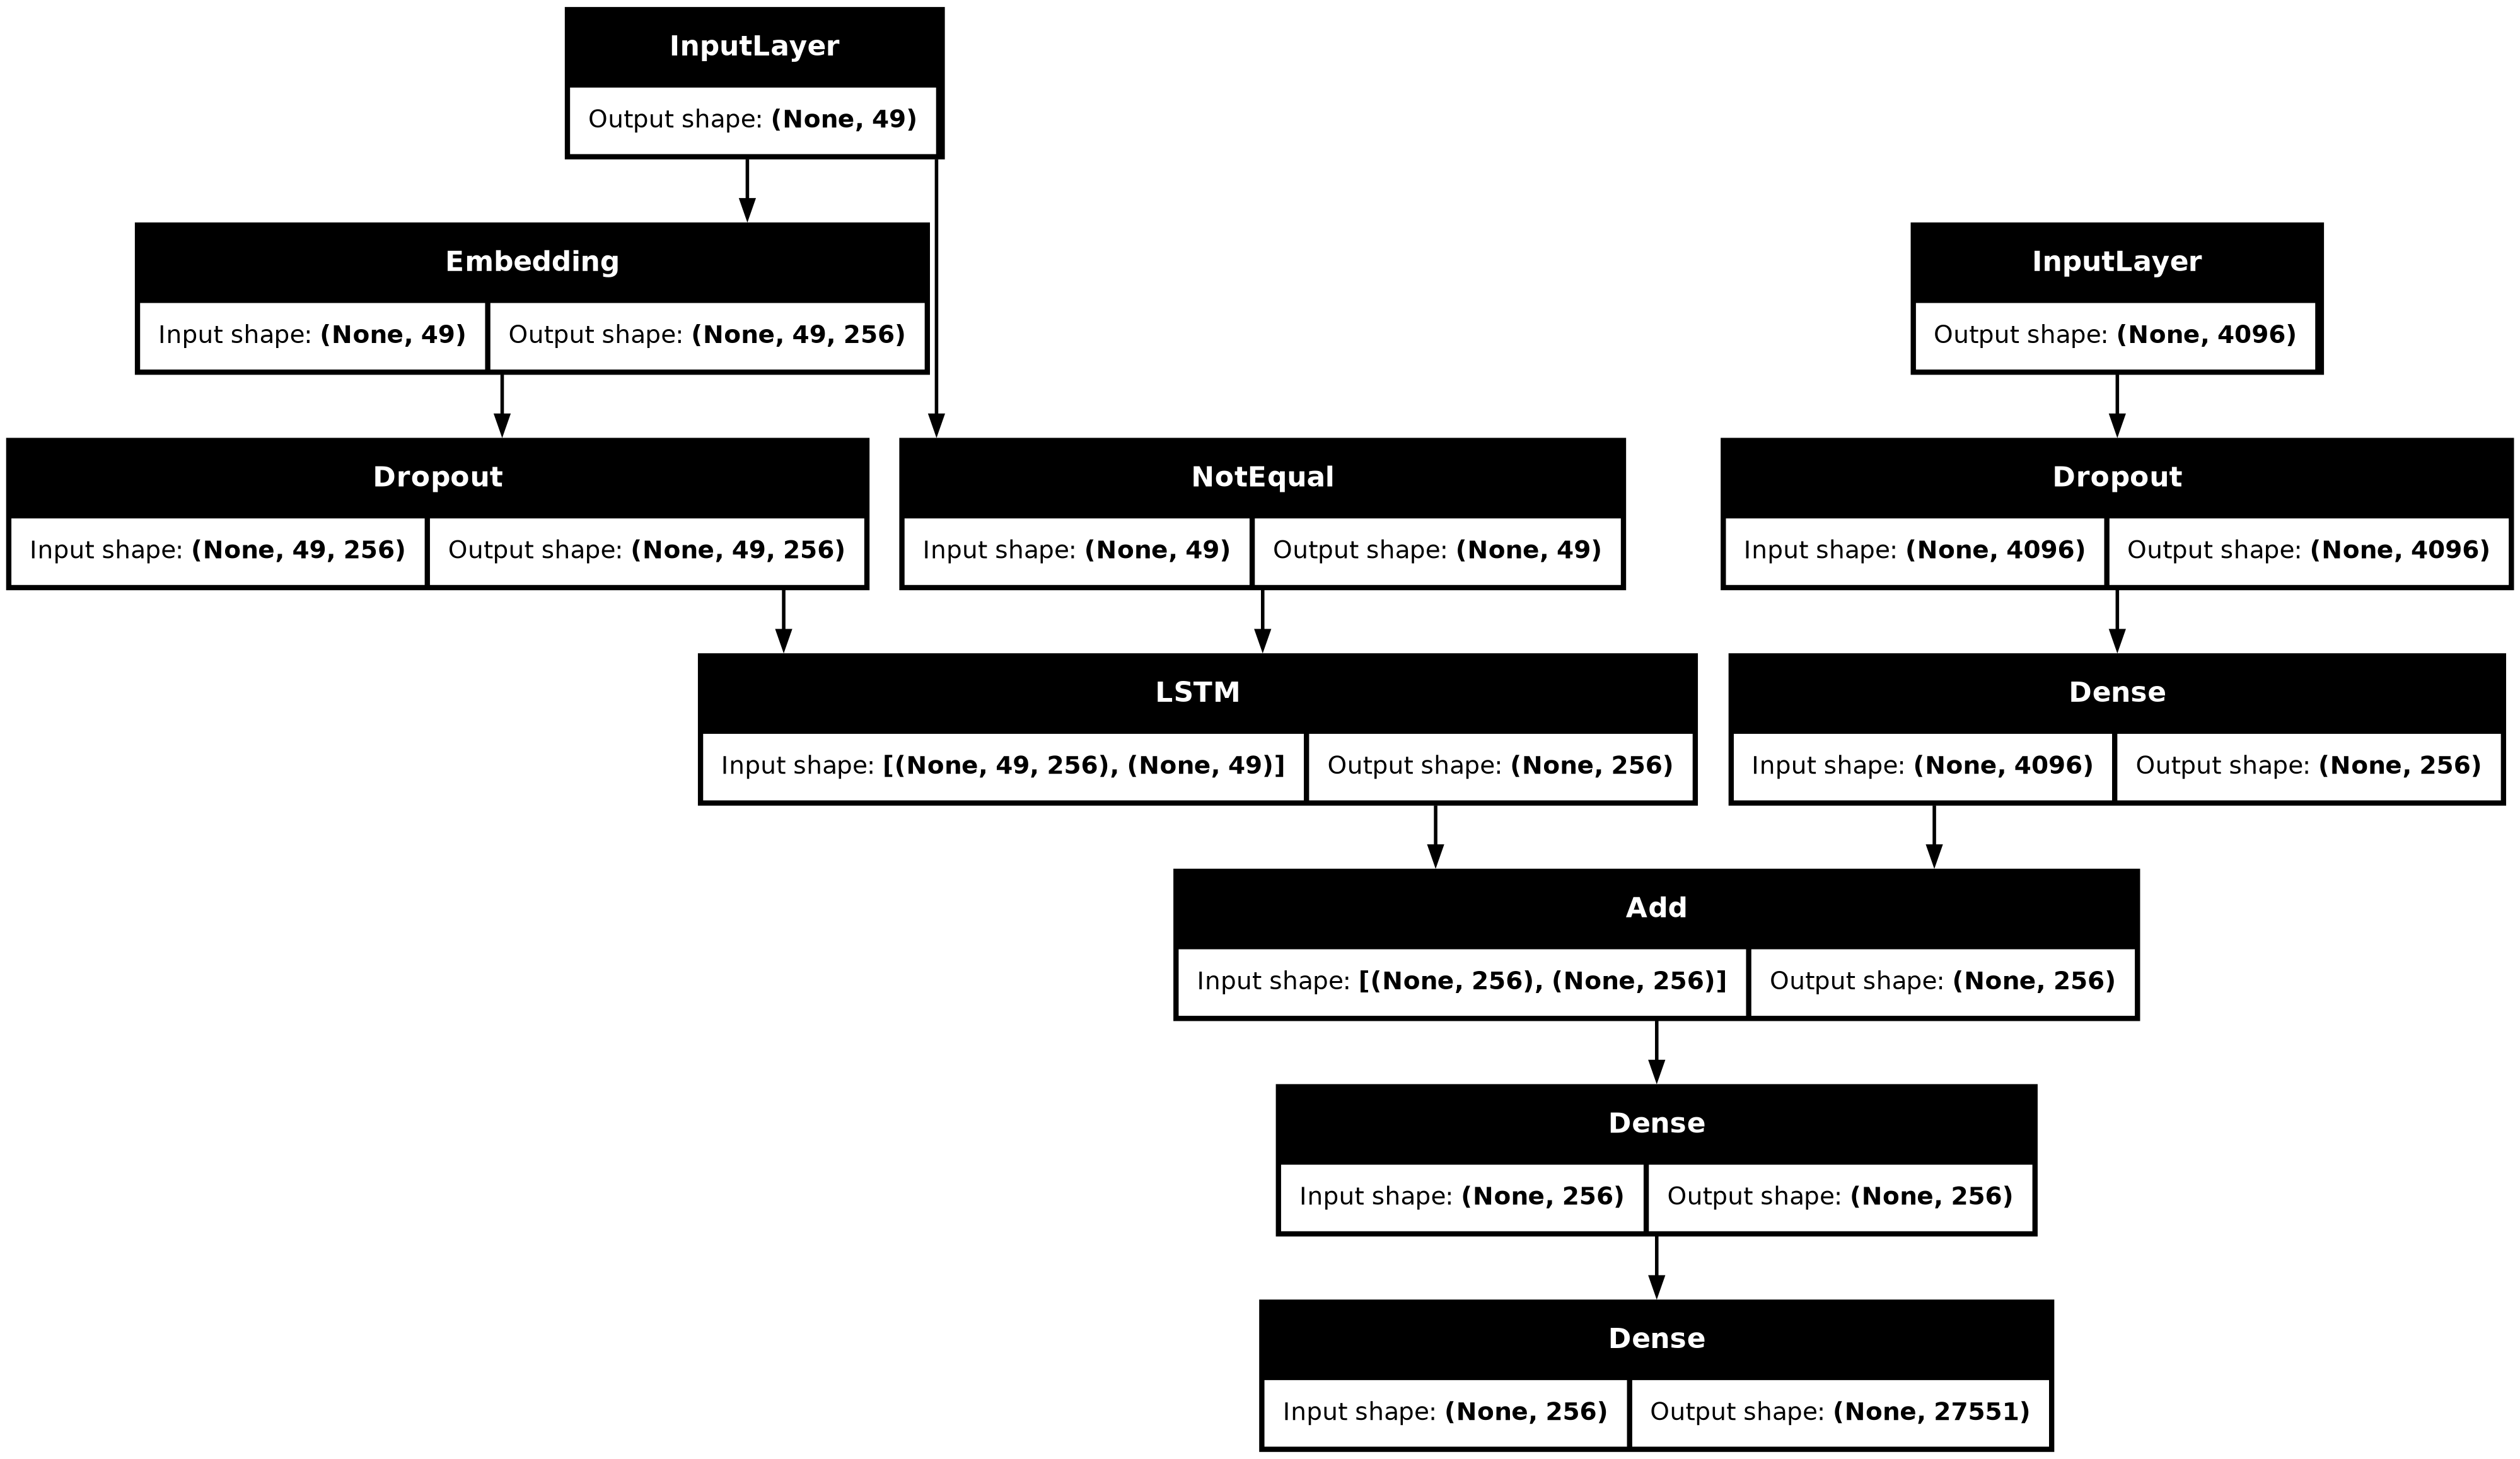

In [20]:
# plot the model
plot_model(model, show_shapes=True)

# Train model LSTM

In [24]:
# from keras.callbacks import Callback

# class BatchLossTrainLogger(Callback):
#     def on_train_batch_end(self, batch, logs=None):
#         # Log loss for each batch
#         wandb.log({"batch_loss": logs["loss"], "batch": batch + 1})
# class BatchLossValLogger(Callback):
#     def on_train_batch_end(self, batch, logs=None):
#         # Log loss for each batch
#         wandb.log({"batch_val_loss": logs["loss"], "batch": batch + 1})

In [21]:
loss = []
val_loss = []

In [22]:
train = list(mapping_train.keys())
val = list(mapping_val.keys())
steps = len(train) // BATCH_SIZE
val_steps = len(val) // BATCH_SIZE

for epoch in range(EPOCHS):
    epoch_loss = 0
    train_data_generator = data_generator(train, mapping_train, features_train, tokenizer, max_length, vocab_size, BATCH_SIZE)
    val_generator = data_generator(val, mapping_val, features_val, tokenizer, max_length, vocab_size, BATCH_SIZE)

    # fit for one epoch
    history = model.fit(train_data_generator, 
                        epochs=1, 
                        steps_per_epoch=steps,
                        validation_data=val_generator,
                        validation_steps=val_steps,
                        verbose=1
                       )
    loss.append(history.history["loss"][0])
    val_loss.append(history.history["val_loss"][0])
# Finish the wandb run
model.save(WORKING_DIR + 'Img_caption_model.keras') # save for working

1848/1848 ━━━━━━━━━━━━━━━━━━━━ 2036s 1s/step - loss: 2.7189 - val_loss: 3.0020
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 2092s 1s/step - loss: 2.6891 - val_loss: 3.0059


In [23]:
history.history

{'loss': [2.7420244216918945], 'val_loss': [2.9910380840301514]}

loss = [2.948169469833374, 2.854462146759033, 2.788686513900757, 2.7420244216918945, 2.708261489868164, 2.6807444095611572]

val_loss = [3.0145034790039062, 2.988564968109131, 2.9886815547943115, 2.9910380840301514, 3.002047061920166, 3.005925416946411]

In [23]:
loss

[2.708261489868164, 2.6807444095611572]

In [24]:
val_loss

[3.002047061920166, 3.005925416946411]

In [26]:
# Save the model
model.save(WORKING_DIR + 'Img_caption_model.keras') # save for working

# Generate caption for image

In [25]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [26]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'seqstart'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'seqend':
            break
    return in_text

In [27]:
from PIL import Image
import matplotlib.pyplot as plt
def visualize_the_result(image_name):
    # Load the image
    image_name = image_name
    image_id = image_name.split('.')[0]
    image_path = os.path.join("/kaggle/input/coco-2017-dataset/coco2017/val2017", image_name)
    image = Image.open(image_path)
    captions = mapping_val[image_id]
    print("----------------------Actual----------------------")
    for caption in captions:
        print(caption)
    
    # Predicted caption
    y_pred = predict_caption(model, features_val[image_id], tokenizer, max_length)
    print("----------------------Predicted----------------------")
    print(y_pred)
    plt.imshow(image)

----------------------Actual----------------------
seqstart cat resting on an open laptop computer. seqend
seqstart black fluffy cat sitting on top of computer keyboard. seqend
seqstart black cat is sitting on metal platform. seqend
seqstart the large cat is resting comfortably behind the laptop screen. seqend
seqstart black and white cat relaxing inside laptop. seqend
----------------------Predicted----------------------
seqstart cat laying on top of laptop computer seqend


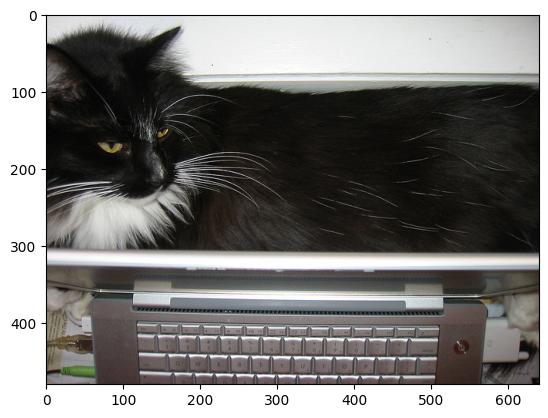

In [42]:
visualize_the_result("000000001675.jpg")